In [1]:

import torch
from time import time
from DocBuilder.utils import split_list_to_batch, restore_batched_list, unbind_sparse, top_k_sparse, tensor_retuen_type
from DocBuilder.Retriever_k_means import cluster_builder
import matplotlib.pyplot as plt
import numpy as np

/root/miniconda3/envs/RR/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


3220


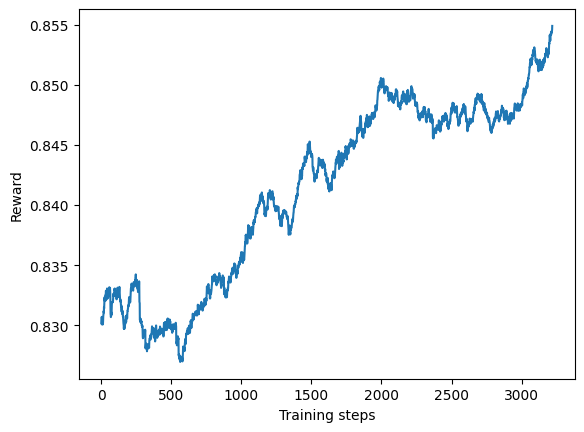

In [38]:

with open("reward_number.txt", "r") as f:
    r = f.readlines()
r = [float(i) for i in r][:]
print(len(r))
moving_avg = []
ma = np.mean(r[:500])
ratio=1-5/len(r)
for x in r:
    ma = ratio * ma + (1-ratio) * x
    moving_avg.append(ma)

plt.ylabel("Reward")
plt.xlabel("Training steps")
plt.plot(moving_avg)
plt.show()

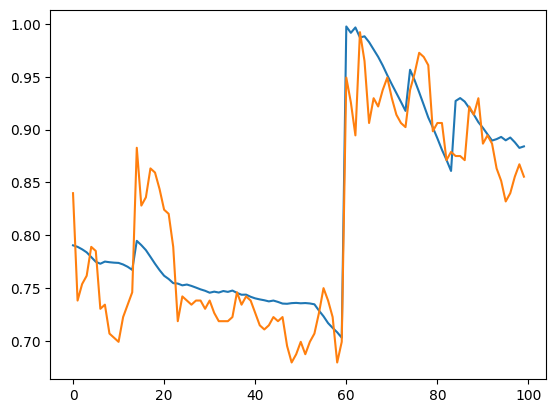

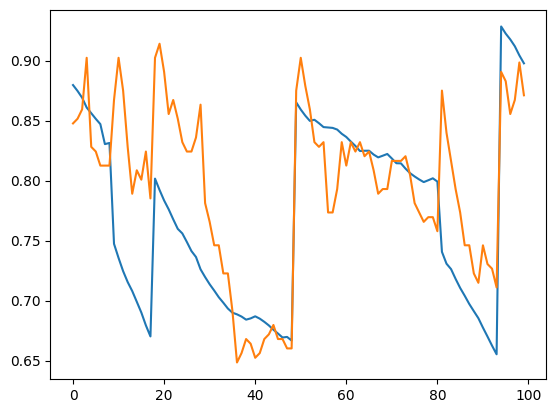

In [39]:
returns = torch.load("save/return.pt")
value = torch.load("save/value.pt")
plt.plot(returns[:100])
plt.plot(value[:100])
plt.show()
plt.plot(returns[100:200])
plt.plot(value[100:200])
plt.show()

In [44]:
from LM.llama_reader import LLaMa_reader
import config
from metric.reward import Bert_score
g_config= config.generate_config
g_config.temperature=0.1
model = LLaMa_reader(config.LM_dir, device="cuda:1",generate_config=g_config)

Loading checkpoint shards: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

["\nson Sav\nbornarch 2, 1931 -June 2, 1013) was an American actor best film person, best commonly for his port as Young young George Bailey in the's a Wonderful Life ("]


(tensor(0.6838),)

In [166]:

# output = model.generate("hello", max_new_tokens=20)
messages = "who is young george bailey in it's a wonderful life"
y = "Robert James Anderson (March 6, 1933--June 6, 2008) was an American actor and television producer, most famous for his role as the young George Bailey in It's a Wonderful Life."
response = model.pseudo_generate(messages, y, temperture=0.2, return_prob=False, decode=True)
print(response)
Bert_score([y], response)

["\nson Brad\nbornarch 2, 1939 -June 2, 1013) was an American actor best film person. best famous for his role as Young young George Bailey in the's a Wonderful Life ("]


(tensor(0.7152),)

In [8]:
token, prob = model.pseudo_generate("hello!","I'm Amber and I'm so glad you're here!", temperture=0.5,return_prob=True)

In [19]:

from transformers import BertModel, BertConfig, BertTokenizer, RobertaModel, RobertaTokenizer, RobertaForMaskedLM
import config, torch
bert = RobertaForMaskedLM.from_pretrained(config.roberta_dir, torch_dtype=torch.bfloat16).to(torch.bfloat16)
embedding = bert.roberta.embeddings.position_embeddings
new_embedding = torch.nn.modules.sparse.Embedding(1026, embedding.embedding_dim, embedding.padding_idx, embedding.max_norm, embedding.norm_type, embedding.scale_grad_by_freq, embedding.sparse, dtype = torch.bfloat16)
new_embedding.weight.data[:len(embedding.weight),:]=embedding.weight.data
bert.roberta.embeddings.position_embeddings = new_embedding
print(embedding.weight.data.shape)
tokenizer = RobertaTokenizer.from_pretrained(config.roberta_dir)
tokenizer("".join([" retrieve"," proceed"," rewrite"]*3))

torch.Size([514, 768])


{'input_ids': [0, 22661, 9073, 27549, 22661, 9073, 27549, 22661, 9073, 27549, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [12]:
print(token, prob[0])

["I'm aber. I'm a glad you're here!"] tensor([-1.3740e-01, -1.7198e-01, -2.2888e-05, -9.2111e+00, -6.3116e-01,
        -1.7403e+00, -1.1700e-02, -3.0346e-02, -3.4332e-05, -4.0004e-01,
        -1.1650e-02, -7.6294e-06, -1.5945e-03, -1.2207e-04, -3.8147e-06,
        -1.2722e-01])
